In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-year-project/NeighRadius.csv
/kaggle/input/final-year-project/Radius.csv
/kaggle/input/final-year-project/Face.csv
/kaggle/input/final-year-project/NeighFace.csv


In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


In [37]:
df_face = pd.read_csv('/kaggle/input/final-year-project/Face.csv')
df_neigh_face= pd.read_csv('/kaggle/input/final-year-project/NeighFace.csv')
df_neigh_radius= pd.read_csv('/kaggle/input/final-year-project/NeighRadius.csv')
df_radius = pd.read_csv('/kaggle/input/final-year-project/Radius.csv')

In [38]:
df_face

,Unnamed: 0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t1873,t1874,t1875,t1876,t1877,t1878,t1879,t1880,t1881,t1882
0,g1,16,16,16,16,16,16,16,16,16,...,0,0,0,0,0,0,0,0,0,0
1,g2,28,27,27,27,25,25,25,25,25,...,21,21,21,21,21,21,21,21,21,21
2,g3,16,16,16,16,16,16,16,16,16,...,0,0,0,0,0,0,0,0,0,0
3,g4,13,13,13,12,12,12,12,12,12,...,0,0,0,0,0,0,0,0,0,0
4,g5,12,12,12,12,12,12,12,12,12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,g4996,18,18,18,18,18,18,18,18,18,...,0,0,0,0,0,0,0,0,0,0
4996,g4997,26,26,26,26,26,26,26,26,26,...,16,16,16,16,16,16,16,16,16,16
4997,g4998,14,12,12,13,13,14,13,13,13,...,0,0,0,0,0,0,0,0,0,0
4998,g4999,20,20,20,20,20,20,20,20,20,...,0,0,0,0,0,0,0,0,0,0


In [39]:
columns_to_keep = ['Unnamed: 0'] + [f't{i}' for i in range(100, 1100)]

In [40]:
df_face_filtered = df_face[columns_to_keep]
df_neigh_face_filtered = df_neigh_face[columns_to_keep]
df_neigh_radius_filtered = df_neigh_radius[columns_to_keep]
df_radius_filtered = df_radius[columns_to_keep]

In [41]:
df_face_filtered

,Unnamed: 0,t100,t101,t102,t103,t104,t105,t106,t107,t108,...,t1090,t1091,t1092,t1093,t1094,t1095,t1096,t1097,t1098,t1099
0,g1,13,13,13,13,13,13,13,13,13,...,0,0,0,0,0,0,0,0,0,0
1,g2,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2,g3,13,13,13,13,13,13,13,13,13,...,0,0,0,0,0,0,0,0,0,0
3,g4,10,10,10,10,10,10,4,9,9,...,0,0,0,0,0,0,0,0,0,0
4,g5,11,11,11,11,11,11,11,11,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,g4996,15,15,15,15,15,15,15,15,15,...,0,0,0,0,0,0,0,0,0,0
4996,g4997,24,24,24,24,24,24,24,24,24,...,22,22,22,22,22,22,22,22,22,22
4997,g4998,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
4998,g4999,18,18,18,18,18,18,18,18,18,...,12,12,12,12,12,12,12,12,12,12


In [42]:
# Initialize lists to store metrics
avg_rmse_train = []
avg_rmse_test = []
avg_r2_train = []
avg_r2_test = []
equations = []

In [43]:
timeframes = [f't{i}' for i in range(100, 1100)]

Models that give direct equations:
* Linear Regression
* Polynomial Regression
* Ridge and Lasso Regression
* Generalized Linear Models (GLM)
* Elastic Net Regression

# **Elastic Net Regression** 
 **(Most advanced one)**

In [44]:
for timeframe in timeframes:
    # Merging dataframes as per the specific timeframe
    df_merged = df_radius_filtered[['Unnamed: 0', timeframe]].rename(columns={timeframe: 'Radius'})
    df_merged = df_merged.merge(df_face_filtered[['Unnamed: 0', timeframe]], on='Unnamed: 0').rename(columns={timeframe: 'Face'})
    df_merged = df_merged.merge(df_neigh_radius_filtered[['Unnamed: 0', timeframe]], on='Unnamed: 0').rename(columns={timeframe: 'NeighRadius'})
    df_merged = df_merged.merge(df_neigh_face_filtered[['Unnamed: 0', timeframe]], on='Unnamed: 0').rename(columns={timeframe: 'NeighFace'})

    X = df_merged[['Face', 'NeighRadius', 'NeighFace']]
    y = df_merged['Radius']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    # Define a pipeline with StandardScaler, PolynomialFeatures, and ElasticNet
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('elasticnet', ElasticNet(random_state=42))
    ])

    # Parameter grid for GridSearchCV
    param_grid = {
        'elasticnet__alpha': [0.1, 1, 10],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    }

    # GridSearchCV to find the best parameters
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='r2', verbose=0)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate and store metrics
    avg_rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    avg_rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    avg_r2_train.append(r2_score(y_train, y_train_pred))
    avg_r2_test.append(r2_score(y_test, y_test_pred))

    # Store the equation coefficients
    coef = best_model.named_steps['elasticnet'].coef_
    intercept = best_model.named_steps['elasticnet'].intercept_
    equation = f"Radius = {intercept:.4f} + {coef[1]:.4f}*Face + {coef[2]:.4f}*NeighRadius + {coef[3]:.4f}*NeighFace"
    equations.append(equation)
   

In [45]:
# Output average metrics and equations
print(f"Average RMSE Train: {np.mean(avg_rmse_train)}")
print(f"Average RMSE Test: {np.mean(avg_rmse_test)}")
print(f"Average R² Train: {np.mean(avg_r2_train)}")
print(f"Average R² Test: {np.mean(avg_r2_test)}")

Average RMSE Train: 1.0413110506917858
Average RMSE Test: 1.0513440095071818
Average R² Train: 0.9716251115933928
Average R² Test: 0.970639770887034


**R2 score = 0.97**

In [46]:
equations[0:5]

['Radius = 10.0635 + 2.6895*Face + 1.2199*NeighRadius + 0.0000*NeighFace',
 'Radius = 10.0581 + 2.7057*Face + 1.2049*NeighRadius + 0.0000*NeighFace',
 'Radius = 10.0372 + 2.7250*Face + 1.2071*NeighRadius + 0.0000*NeighFace',
 'Radius = 10.0201 + 2.7470*Face + 1.2173*NeighRadius + 0.0000*NeighFace',
 'Radius = 10.0106 + 2.7676*Face + 1.2071*NeighRadius + 0.0000*NeighFace']

In [47]:
coefficients = []
for eq in equations:
    matches = re.findall(r'([-+]?\d*\.\d+|\d+)', eq)
    if matches and len(matches) >= 4:
        const = float(matches[0])  # Intercept
        face_coef = float(matches[1])  # Face coefficient
        neigh_radius_coef = float(matches[2])  # NeighRadius coefficient
        neigh_face_coef = float(matches[3])  # NeighFace coefficient
        coefficients.append({
            'Timestamp': timeframes[len(coefficients)],  # Assuming the timeframes align with the order
            'Constant': const,
            'Face': face_coef,
            'NeighRadius': neigh_radius_coef,
            'NeighFace': neigh_face_coef
        })


In [48]:
# Create a DataFrame from the coefficients
coefficients_df = pd.DataFrame(coefficients)

In [49]:
coefficients_df

,Timestamp,Constant,Face,NeighRadius,NeighFace
0,t100,10.0635,2.6895,1.2199,0.0000
1,t101,10.0581,2.7057,1.2049,0.0000
2,t102,10.0372,2.7250,1.2071,0.0000
3,t103,10.0201,2.7470,1.2173,0.0000
4,t104,10.0106,2.7676,1.2071,0.0000
...,...,...,...,...,...
995,t1095,-0.1752,0.8800,0.3221,0.1346
996,t1096,-0.1606,0.8931,0.3235,0.1420
997,t1097,-0.1589,0.8975,0.3246,0.1361
998,t1098,-0.1573,0.8932,0.3239,0.1411


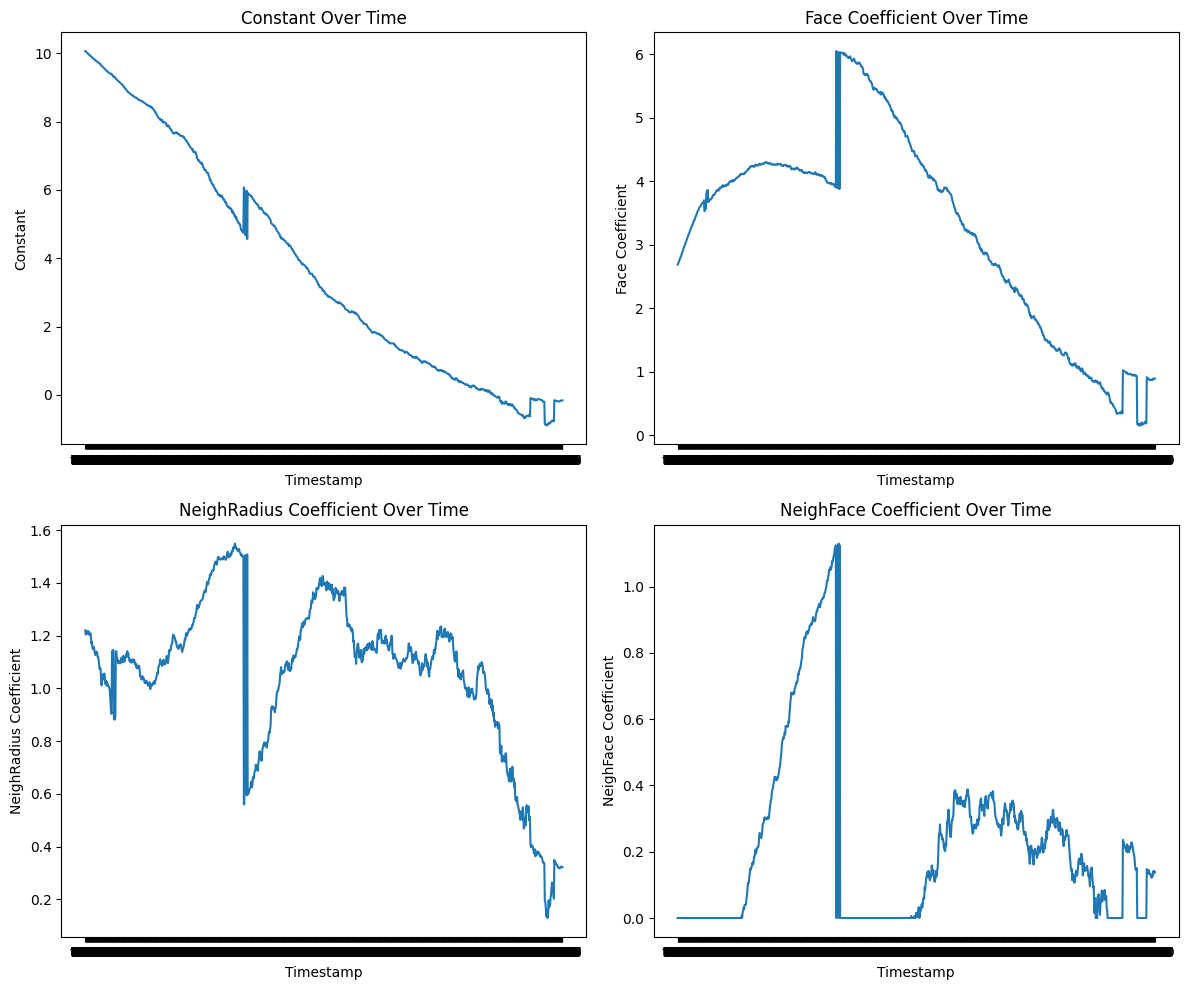

In [50]:
# Plotting the coefficients over time
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Constant plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='Constant', ax=axs[0, 0])
axs[0, 0].set_title("Constant Over Time")
axs[0, 0].set_xlabel("Timestamp")
axs[0, 0].set_ylabel("Constant")

# Face coefficient plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='Face', ax=axs[0, 1])
axs[0, 1].set_title("Face Coefficient Over Time")
axs[0, 1].set_xlabel("Timestamp")
axs[0, 1].set_ylabel("Face Coefficient")

# NeighRadius coefficient plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='NeighRadius', ax=axs[1, 0])
axs[1, 0].set_title("NeighRadius Coefficient Over Time")
axs[1, 0].set_xlabel("Timestamp")
axs[1, 0].set_ylabel("NeighRadius Coefficient")

# NeighFace coefficient plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='NeighFace', ax=axs[1, 1])
axs[1, 1].set_title("NeighFace Coefficient Over Time")
axs[1, 1].set_xlabel("Timestamp")
axs[1, 1].set_ylabel("NeighFace Coefficient")

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig("coefficients_over_time.jpg", format='jpg')